In [1]:
import pandas as pd
import numpy as np
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from IPython.display import display

In [2]:
spark = SparkSession.builder.master("local[*]") \
.appName('Spark_App') \
.getOrCreate()

In [3]:
import datetime
from pyspark.sql import Window
from pyspark.sql.functions import lit, col, when, log
from pyspark.ml.feature import StringIndexer, OneHotEncoder, MaxAbsScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt

## Step 1. Load the dataset

In [4]:
credit_data = pd.read_hdf('credit_data.h5', 'df')
credit_data_sdf = spark.createDataFrame(credit_data)

## Data Exploration

In [5]:
print(credit_data_sdf.count())

5000


In [6]:
display(credit_data_sdf.select('*').limit(5).toPandas())

,CustomerID,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,713a336c-a255-4e2d-9d57-90b3e99e2f06,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
1,140b363f-a3fe-4828-a33f-7284dfdb3969,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,...,savings_insurance,37,stores,own,2,skilled,1,none,yes,No Risk
2,43b7b51d-5eda-4860-b461-ebef3d3436f4,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,...,real_estate,28,none,own,2,skilled,1,yes,no,No Risk
3,f40eaf08-e6d1-4765-ab20-c5f7faca1635,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
4,1728910a-d3ff-4799-ac50-203a3a58a3fb,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,...,unknown,57,none,own,2,skilled,1,none,yes,Risk


In [7]:
display(credit_data_sdf
        .select("LoanAmount")
        .summary()
        .toPandas())

,summary,LoanAmount
0,count,5000
1,mean,3480.145
2,stddev,2488.232782689588
3,min,250
4,25%,1326
5,50%,3237
6,75%,5355
7,max,11676


In [8]:
display(credit_data_sdf
        .groupBy("LoanPurpose")
        .count()
        .sort("count", ascending=False)
        .toPandas())

,LoanPurpose,count
0,car_new,945
1,furniture,853
2,car_used,808
3,radio_tv,755
4,appliances,561
5,repairs,283
6,vacation,205
7,education,167
8,retraining,164
9,business,146


## Background: Transformers, estimators, and pipelines
## Step 2. Feature preprocessing
## Convert categorical variables to numeric

In [9]:
credit_data_sdf.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- CheckingStatus: string (nullable = true)
 |-- LoanDuration: long (nullable = true)
 |-- CreditHistory: string (nullable = true)
 |-- LoanPurpose: string (nullable = true)
 |-- LoanAmount: long (nullable = true)
 |-- ExistingSavings: string (nullable = true)
 |-- EmploymentDuration: string (nullable = true)
 |-- InstallmentPercent: long (nullable = true)
 |-- Sex: string (nullable = true)
 |-- OthersOnLoan: string (nullable = true)
 |-- CurrentResidenceDuration: long (nullable = true)
 |-- OwnsProperty: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- InstallmentPlans: string (nullable = true)
 |-- Housing: string (nullable = true)
 |-- ExistingCreditsCount: long (nullable = true)
 |-- Job: string (nullable = true)
 |-- Dependents: long (nullable = true)
 |-- Telephone: string (nullable = true)
 |-- ForeignWorker: string (nullable = true)
 |-- Risk: string (nullable = true)



In [10]:
#Get All column names and it's types
for field in credit_data_sdf.schema.fields:
    print(field.name +", "+str(field.dataType))

CustomerID, StringType()
CheckingStatus, StringType()
LoanDuration, LongType()
CreditHistory, StringType()
LoanPurpose, StringType()
LoanAmount, LongType()
ExistingSavings, StringType()
EmploymentDuration, StringType()
InstallmentPercent, LongType()
Sex, StringType()
OthersOnLoan, StringType()
CurrentResidenceDuration, LongType()
OwnsProperty, StringType()
Age, LongType()
InstallmentPlans, StringType()
Housing, StringType()
ExistingCreditsCount, LongType()
Job, StringType()
Dependents, LongType()
Telephone, StringType()
ForeignWorker, StringType()
Risk, StringType()


In [11]:
categoricalCols = ['CheckingStatus','CreditHistory','LoanPurpose','ExistingSavings','EmploymentDuration','Sex',
'OthersOnLoan','OwnsProperty','InstallmentPlans','Housing','Job','Telephone','ForeignWorker']

In [12]:
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=[x + "Index" for x in categoricalCols], stringOrderType = 'frequencyDesc') 
encoder = OneHotEncoder(inputCols=stringIndexer.getOutputCols(), outputCols=[x + "OHE" for x in categoricalCols], dropLast = False)

In [13]:
labelToIndex = StringIndexer(inputCol="Risk", outputCol="label", stringOrderType = 'alphabetAsc')

In [14]:
#Fits a model to the input dataset with optional parameters.
df1 = stringIndexer.fit(credit_data_sdf).transform(credit_data_sdf)
display(df1.select('OwnsProperty', 'OwnsPropertyIndex').limit(10).toPandas())

,OwnsProperty,OwnsPropertyIndex
0,savings_insurance,0.0
1,savings_insurance,0.0
2,real_estate,2.0
3,savings_insurance,0.0
4,unknown,3.0
5,unknown,3.0
6,savings_insurance,0.0
7,car_other,1.0
8,savings_insurance,0.0
9,unknown,3.0


In [15]:
#Fits a model to the input dataset with optional parameters.
df2 = encoder.fit(df1).transform(df1)
display(df2.select('OwnsProperty', 'OwnsPropertyIndex','OwnsPropertyOHE').limit(10).toPandas())

,OwnsProperty,OwnsPropertyIndex,OwnsPropertyOHE
0,savings_insurance,0.0,"(1.0, 0.0, 0.0, 0.0)"
1,savings_insurance,0.0,"(1.0, 0.0, 0.0, 0.0)"
2,real_estate,2.0,"(0.0, 0.0, 1.0, 0.0)"
3,savings_insurance,0.0,"(1.0, 0.0, 0.0, 0.0)"
4,unknown,3.0,"(0.0, 0.0, 0.0, 1.0)"
5,unknown,3.0,"(0.0, 0.0, 0.0, 1.0)"
6,savings_insurance,0.0,"(1.0, 0.0, 0.0, 0.0)"
7,car_other,1.0,"(0.0, 1.0, 0.0, 0.0)"
8,savings_insurance,0.0,"(1.0, 0.0, 0.0, 0.0)"
9,unknown,3.0,"(0.0, 0.0, 0.0, 1.0)"


In [16]:
df3 = labelToIndex.fit(credit_data_sdf).transform(credit_data_sdf)
display(df3.select('Risk', 'label').limit(10).toPandas())

,Risk,label
0,No Risk,0.0
1,No Risk,0.0
2,No Risk,0.0
3,No Risk,0.0
4,Risk,1.0
5,Risk,1.0
6,No Risk,0.0
7,No Risk,0.0
8,No Risk,0.0
9,Risk,1.0


## Combine all feature columns into a single feature vector

In [17]:
# This includes both the numeric columns and the one-hot encoded binary vector columns in our dataset.
numericCols = ['LoanDuration','LoanAmount','InstallmentPercent','CurrentResidenceDuration','Age','ExistingCreditsCount','Dependents']
assemblerInputs =  numericCols + [c + "OHE" for c in categoricalCols]
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol = "features")
scaler = MaxAbsScaler(inputCol="features", outputCol="features_scaled")

In [18]:
df_va = vecAssembler.transform(df2)
df_scaler = scaler.fit(df_va).transform(df_va)
display(df_scaler.select('LoanDuration', 'OwnsProperty', 'OwnsPropertyIndex','OwnsPropertyOHE', 'features', 'features_scaled').limit(10).toPandas())

,LoanDuration,OwnsProperty,OwnsPropertyIndex,OwnsPropertyOHE,features,features_scaled
0,31,savings_insurance,0.0,"(1.0, 0.0, 0.0, 0.0)","(31.0, 1889.0, 3.0, 3.0, 32.0, 1.0, 1.0, 0.0, ...","(0.484375, 0.1617848578280233, 0.5, 0.5, 0.432..."
1,18,savings_insurance,0.0,"(1.0, 0.0, 0.0, 0.0)","(18.0, 462.0, 2.0, 2.0, 37.0, 2.0, 1.0, 0.0, 1...","(0.28125, 0.03956834532374101, 0.3333333333333..."
2,15,real_estate,2.0,"(0.0, 0.0, 1.0, 0.0)","(15.0, 250.0, 2.0, 3.0, 28.0, 2.0, 1.0, 0.0, 1...","(0.234375, 0.021411442274751627, 0.33333333333..."
3,28,savings_insurance,0.0,"(1.0, 0.0, 0.0, 0.0)","(28.0, 3693.0, 3.0, 2.0, 32.0, 1.0, 1.0, 0.0, ...","(0.4375, 0.31628982528263105, 0.5, 0.333333333..."
4,28,unknown,3.0,"(0.0, 0.0, 0.0, 1.0)","(28.0, 6235.0, 3.0, 3.0, 57.0, 2.0, 1.0, 1.0, ...","(0.4375, 0.5340013703323055, 0.5, 0.5, 0.77027..."
5,32,unknown,3.0,"(0.0, 0.0, 0.0, 1.0)","(32.0, 9604.0, 6.0, 5.0, 57.0, 2.0, 2.0, 1.0, ...","(0.5, 0.8225419664268585, 1.0, 0.8333333333333..."
6,9,savings_insurance,0.0,"(1.0, 0.0, 0.0, 0.0)","(9.0, 1032.0, 3.0, 4.0, 41.0, 1.0, 1.0, 1.0, 0...","(0.140625, 0.08838643371017472, 0.5, 0.6666666..."
7,16,car_other,1.0,"(0.0, 1.0, 0.0, 0.0)","(16.0, 3109.0, 3.0, 1.0, 36.0, 2.0, 1.0, 0.0, ...","(0.25, 0.2662726961288112, 0.5, 0.166666666666..."
8,11,savings_insurance,0.0,"(1.0, 0.0, 0.0, 0.0)","(11.0, 4553.0, 3.0, 3.0, 22.0, 1.0, 1.0, 0.0, ...","(0.171875, 0.38994518670777667, 0.5, 0.5, 0.29..."
9,35,unknown,3.0,"(0.0, 0.0, 0.0, 1.0)","(35.0, 7138.0, 5.0, 4.0, 49.0, 2.0, 2.0, 1.0, ...","(0.546875, 0.6113394998287085, 0.8333333333333..."


## Step 3. Define the model

In [19]:
lr = LogisticRegression(featuresCol="features_scaled", labelCol="label")

## Step 4. Build the pipeline

In [20]:
# Define the pipeline based on the stages created in previous steps.
pipeline = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, scaler, lr])
 
# Define the pipeline model.
pipelineModel = pipeline.fit(credit_data_sdf)
 
# Apply the pipeline model to the test dataset.
predDF = pipelineModel.transform(credit_data_sdf)

In [21]:
display(predDF.select("features_scaled", "label", "prediction", "probability").limit(10).toPandas())

,features_scaled,label,prediction,probability
0,"(0.484375, 0.1617848578280233, 0.5, 0.5, 0.432...",0.0,0.0,"[0.8971023625367915, 0.10289763746320846]"
1,"(0.28125, 0.03956834532374101, 0.3333333333333...",0.0,0.0,"[0.7046075308618366, 0.2953924691381634]"
2,"(0.234375, 0.021411442274751627, 0.33333333333...",0.0,0.0,"[0.8286810984617404, 0.17131890153825957]"
3,"(0.4375, 0.31628982528263105, 0.5, 0.333333333...",0.0,0.0,"[0.6911169272059807, 0.3088830727940193]"
4,"(0.4375, 0.5340013703323055, 0.5, 0.5, 0.77027...",1.0,1.0,"[0.14541828869486592, 0.854581711305134]"
5,"(0.5, 0.8225419664268585, 1.0, 0.8333333333333...",1.0,1.0,"[0.10487371289661657, 0.8951262871033834]"
6,"(0.140625, 0.08838643371017472, 0.5, 0.6666666...",0.0,0.0,"[0.7192112859799972, 0.2807887140200028]"
7,"(0.25, 0.2662726961288112, 0.5, 0.166666666666...",0.0,0.0,"[0.7826812656750418, 0.21731873432495818]"
8,"(0.171875, 0.38994518670777667, 0.5, 0.5, 0.29...",0.0,0.0,"[0.9044595084800232, 0.09554049151997679]"
9,"(0.546875, 0.6113394998287085, 0.8333333333333...",1.0,1.0,"[0.05780185421056835, 0.9421981457894316]"


## Step 5. Evaluate the model

Train Area Under ROC:0.8662
Train Gini:0.7325


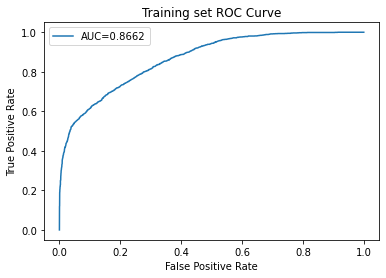

In [22]:
trainingSummary = pipelineModel.stages[-1].summary
roc = trainingSummary.roc.toPandas()
auc = trainingSummary.areaUnderROC
gini = 2.0*auc-1.0
print("Train Area Under ROC:" + str(round(auc, 4)))
print("Train Gini:" + str(round(gini, 4)))

#create ROC curve
plt.plot(roc['FPR'], roc['TPR'], label="AUC=" + str(round(auc, 4)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Training set ROC Curve')
plt.legend()
plt.show()

In [23]:
bcEvaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC')
auc = bcEvaluator.evaluate(predDF)
gini = 2.0*auc-1.0
print(f"Area under ROC curve: {round(auc, 4)}")
print(f"Gini: {round(gini, 4)}")
mcEvaluator = MulticlassClassificationEvaluator(labelCol='label', metricName='f1')
f1 = mcEvaluator.evaluate(predDF)
print(f"F1 Score: {round(f1, 4)}")

Area under ROC curve: 0.8662
Gini: 0.7325
F1 Score: 0.7999


## Step 6. Hyperparameter tuning

In [24]:
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

In [25]:
# Create a 3-fold CrossValidator
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=mcEvaluator, numFolds=3, parallelism = 4)
 
# Run cross validations. This step takes a few minutes and returns the best model found from the cross validation.
cvModel = cv.fit(credit_data_sdf)

## Step 7. Make predictions and evaluate model performance

In [26]:
# Use the model identified by the cross-validation to make predictions on the test dataset
cvPredDF = cvModel.transform(credit_data_sdf)
 
# Evaluate the model's performance based on area under the ROC curve and F1 Score
auc = bcEvaluator.evaluate(cvPredDF)
gini = 2.0*auc-1.0
print(f"Area under ROC curve: {round(auc, 4)}")
print(f"Gini: {round(gini, 4)}")
f1 = mcEvaluator.evaluate(cvPredDF)
print(f"F1 Score: {round(f1, 4)}")

Area under ROC curve: 0.8655
Gini: 0.731
F1 Score: 0.7991
